Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,
                                                            shuffle=True,
                                                            seed=123,
                                                            validation_split = 0.2,
                                                            subset = 'training',
                                                            batch_size=batch_size,
                                                            image_size=(img_height,img_width))

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir_test,
                                                            shuffle=True,
                                                            seed=123,
                                                            validation_split = 0.2,
                                                            subset = 'validation',
                                                            batch_size=batch_size,
                                                            image_size=(img_height,img_width))

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [11]:
num_classes = len(class_names)

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

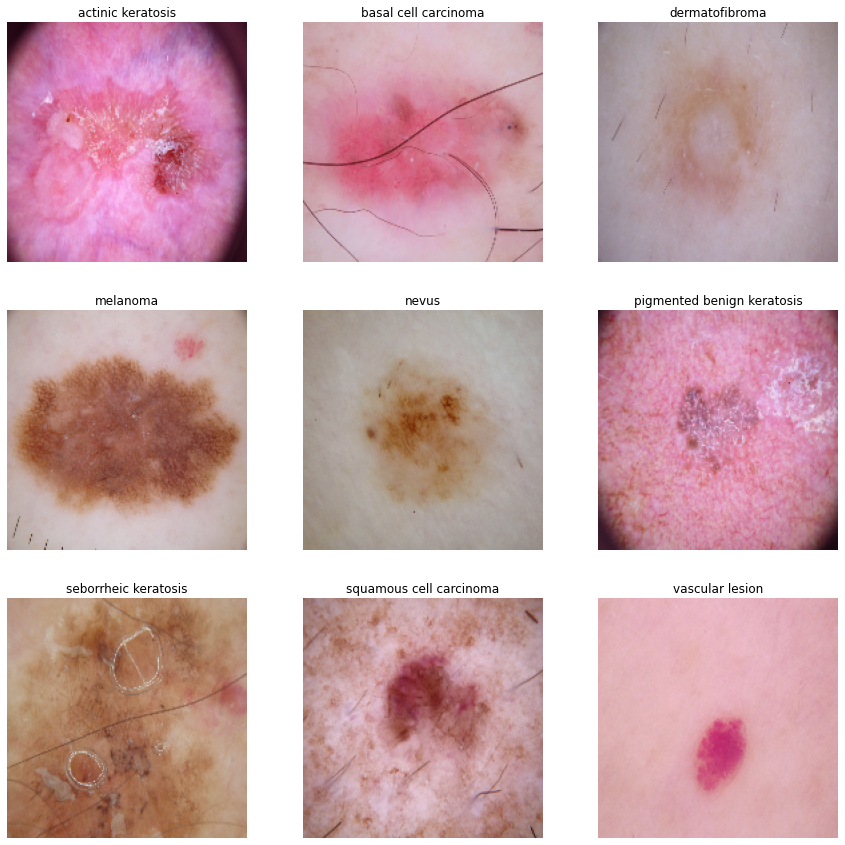

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Image Rescaling
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(len(class_names))
])



### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 664s 262ms/step - loss: 2.1381 - accuracy: 0.2148 - val_loss: 2.2664 - val_accuracy: 0.0435
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.8949 - accuracy: 0.2885 - val_loss: 2.3264 - val_accuracy: 0.1739
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.6288 - accuracy: 0.4263 - val_loss: 3.0310 - val_accuracy: 0.1304
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5484 - accuracy: 0.4626 - val_loss: 2.8034 - val_accuracy: 0.3043
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3714 - accuracy: 0.5184 - val_loss: 2.7849 - val_accuracy: 0.2609
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3152 - accuracy: 0.5368 - val_loss: 2.8904 - val_accuracy: 0.3478
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2584 - accuracy: 0.5502 - val_loss: 3.3086 - val_accuracy: 0.1739
Epoch 8/20

### Visualizing training results

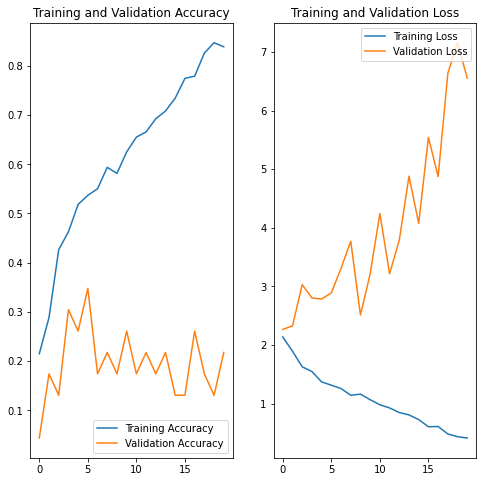

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### There is Major over fitting as validation accuracy is not in sync with the training accuracy. We will try with different model with some changes in the model architecture

### Write your findings here

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

# Data Augumentation changes
augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                    layers.experimental.preprocessing.RandomRotation(0.25),
                                    layers.experimental.preprocessing.RandomZoom(0.25),
                                    layers.experimental.preprocessing.RandomTranslation(.1, .1)
                                    ])

rescaling = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])




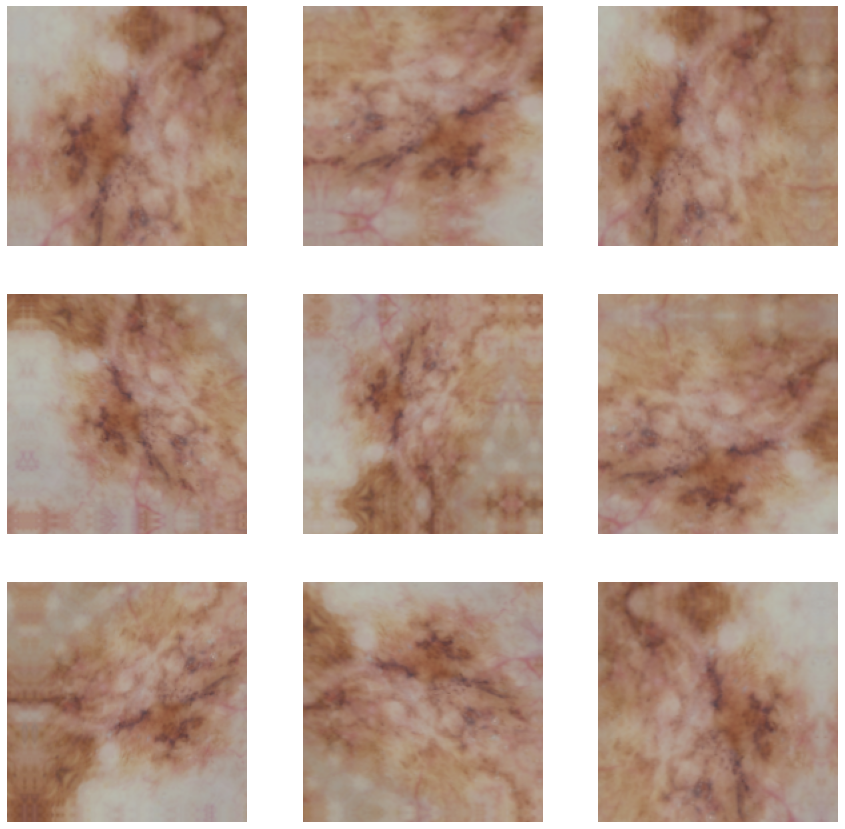

In [19]:
# visualize augmentation strategy for one instance of training image.

plt.figure(figsize=(15, 15))
for images, label in train_ds.take(1):   
    for i in range(9):
        augmented_images = augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off") 

### Todo:
### Create the model, compile and train the model


In [20]:
# ## You can use Dropout layer if there is an evidence of overfitting in your findings
# # model architecture
# model2 = Sequential()
# model2.add(augmentation)
# model2.add(tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)]))
# model2.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))
# # model.add(layers.Conv2D(32, (3, 3), padding='same',
#                 #  input_shape=(img_height,img_width,3)))
# model2.add(layers.Activation('relu'))
# model2.add(layers.Conv2D(32, (3, 3)))
# model2.add(layers.Activation('relu'))
# model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model2.add(layers.Dropout(0.25))

# model2.add(layers.Conv2D(64, (3, 3), padding='same'))
# model2.add(layers.Activation('relu'))
# model2.add(layers.Conv2D(64, (3, 3)))
# model2.add(layers.Activation('relu'))
# model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model2.add(layers.Dropout(0.25))

# model2.add(layers.Flatten())
# model2.add(layers.Dense(512, activation = "relu"))
# model2.add(layers.Dense(256, activation = "relu"))
# model2.add(layers.Dense(128, activation = "relu"))

# model2.add(layers.Activation('relu'))
# model.add(layers.Dropout(0.5))
# model2.add(layers.Dense(len(class_names)))
# model2.add(layers.Activation('softmax'))


model2 = Sequential([
  augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

### Compiling the model

In [21]:
## Your code goes here
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose = 1
)

Epoch 1/20


56/56 [==============================] - 12s 148ms/step - loss: 1.9935 - accuracy: 0.2556 - val_loss: 2.3176 - val_accuracy: 0.2174
Epoch 2/20
56/56 [==============================] - 8s 146ms/step - loss: 1.7794 - accuracy: 0.3326 - val_loss: 2.4477 - val_accuracy: 0.2174
Epoch 3/20
56/56 [==============================] - 8s 148ms/step - loss: 1.6789 - accuracy: 0.3895 - val_loss: 2.3047 - val_accuracy: 0.2609
Epoch 4/20
56/56 [==============================] - 8s 150ms/step - loss: 1.6323 - accuracy: 0.4090 - val_loss: 2.6495 - val_accuracy: 0.3043
Epoch 5/20
56/56 [==============================] - 8s 147ms/step - loss: 1.5678 - accuracy: 0.4336 - val_loss: 2.6176 - val_accuracy: 0.3478
Epoch 6/20
56/56 [==============================] - 8s 146ms/step - loss: 1.5210 - accuracy: 0.4470 - val_loss: 2.8224 - val_accuracy: 0.3043
Epoch 7/20
56/56 [==============================] - 8s 146ms/step - loss: 1.5135 - accuracy: 0.4615 - val_loss: 2.5524 - val_accuracy: 0.3043
Epoch 8/20
56/56

### Visualizing the results

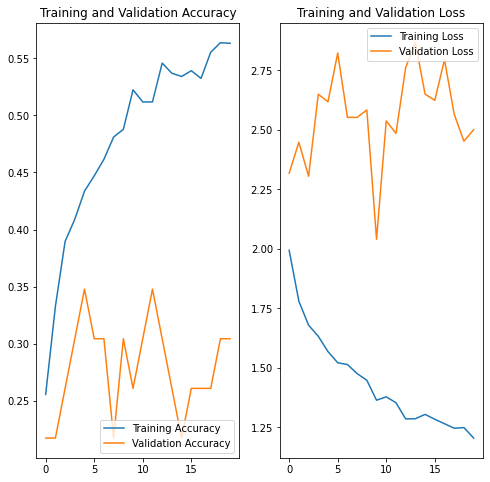

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
## Your code goes here.

import pandas as pd
import os
img_list = []
label_list = []
for label in class_names:
  dir = (str(data_dir_train)+'/'+label)
  print(dir)
  for img_file in os.listdir(dir):
      img_list.append(dir+'/'+img_file)
      label_list.append(label)
      
_df = pd.DataFrame({'img':img_list, 'label':label_list})

/content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
/content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
/content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
/content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
/content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus
/content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
/content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
/content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carci

In [25]:
df_class_count =  _df["label"].value_counts().rename_axis('class_name').reset_index(name='count')
df_class_count

,class_name,count
0,pigmented benign keratosis,462
1,melanoma,438
2,basal cell carcinoma,376
3,nevus,357
4,squamous cell carcinoma,181
5,vascular lesion,139
6,actinic keratosis,114
7,dermatofibroma,95
8,seborrheic keratosis,77


,class_name,count
0,pigmented benign keratosis,462
1,melanoma,438
2,basal cell carcinoma,376
3,nevus,357
4,squamous cell carcinoma,181
5,vascular lesion,139
6,actinic keratosis,114
7,dermatofibroma,95
8,seborrheic keratosis,77


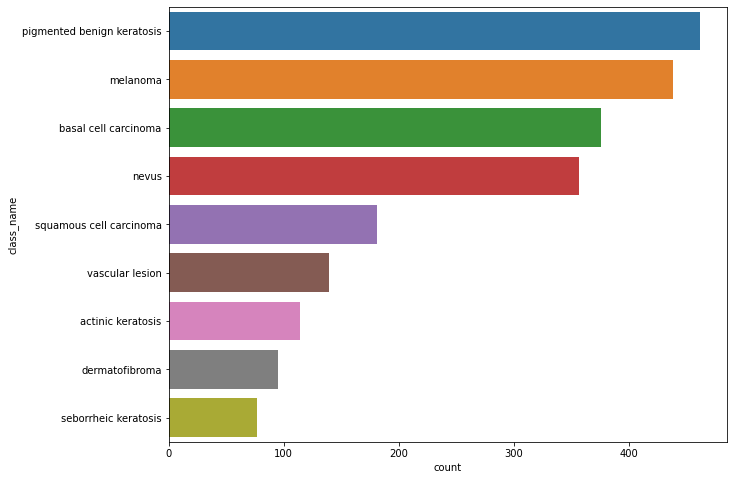

In [27]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="count", y="class_name", data=df_class_count,
            label="Class")
display(df_class_count.sort_values(by='count',ascending= False))

#### Findings - 
#### seborrheic keratosis class has the least number of samples?
#### pigmented benign keratosis class dominate the data in terms proportionate number of samples

## we will perform data augmentation to handle this class imbalance problem.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
path_to_training_dataset= data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline((str(path_to_training_dataset)+'/'+i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F03A832E950>: 100%|██████████| 500/500 [00:18<00:00, 26.82 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F03A9738E10>: 100%|██████████| 500/500 [00:19<00:00, 25.09 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F03C21F0B10>: 100%|██████████| 500/500 [00:19<00:00, 25.83 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0410624710>: 100%|██████████| 500/500 [01:22<00:00,  6.07 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F04255E8F90>: 100%|██████████| 500/500 [01:37<00:00,  5.15 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F03A9252D50>: 100%|██████████| 500/500 [00:18<00:00, 26.91 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F04105EAF90>: 100%|██████████| 500/500 [00:42<00:00, 11.88 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F03A8600C10>: 100%|██████████| 500/500 [00:19<00:00, 26.24 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F03C21F4290>: 100%|██████████| 500/500 [00:19<00:00, 25.39 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [32]:
from glob import glob

### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033811.jpg_df1e1617-257b-4fe5-91fe-4c92b4b72dfc.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030877.jpg_4d07d32e-babb-4584-a14b-5042e46dd2a5.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026212.jpg_79bd7a1b-a723-4058-b6e2-68b393f771b7.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028941.jpg_f155c561-1cb4-4bb8-9345-fae840cca813.jpg',
 '/content/gdrive/MyDrive/Colab_Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/ac

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)
new_df = df2

In [38]:
new_df['Label'].value_counts()

actinic keratosis             500
dermatofibroma                500
seborrheic keratosis          500
melanoma                      500
vascular lesion               500
nevus                         500
basal cell carcinoma          500
squamous cell carcinoma       500
pigmented benign keratosis    500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [39]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [40]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [42]:
# # model architecture
# model3 = Sequential()
# # model3.add(augmentation)
# model3.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))

# model3.add(layers.Activation('relu'))
# model3.add(layers.Conv2D(32, (3, 3)))
# model3.add(layers.Activation('relu'))
# model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model3.add(layers.Dropout(0.25))
# model3.add(layers.BatchNormalization())

# model3.add(layers.Conv2D(64, (3, 3), padding='same'))
# model3.add(layers.Activation('relu'))
# model3.add(layers.Conv2D(64, (3, 3)))
# model3.add(layers.Activation('relu'))
# model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model3.add(layers.Dropout(0.25))
# model3.add(layers.BatchNormalization())


# model3.add(layers.Flatten())
# model3.add(layers.Dense(512, activation = "relu"))
# model3.add(layers.Dense(256, activation = "relu"))
# model3.add(layers.Dense(128, activation = "relu"))

# model3.add(layers.Activation('relu'))
# model3.add(layers.Dropout(0.5))
# model3.add(layers.BatchNormalization())
# model3.add(layers.Dense(len(class_names)))
# model3.add(layers.Activation('softmax'))

In [43]:
model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(len(class_names), name="outputs")
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [44]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


#### **Todo:**  Train your model

In [45]:
epochs = 20
## Your code goes here, use 50 epochs.
history = model.fit(train_ds, validation_data=val_ds,epochs = epochs)

# your model fit code

Epoch 1/20
169/169 [==============================] - 34s 193ms/step - loss: 1.9023 - accuracy: 0.2845 - val_loss: 1.5619 - val_accuracy: 0.4298
Epoch 2/20
169/169 [==============================] - 31s 179ms/step - loss: 1.4184 - accuracy: 0.4661 - val_loss: 1.2908 - val_accuracy: 0.5301
Epoch 3/20
169/169 [==============================] - 32s 181ms/step - loss: 1.2165 - accuracy: 0.5423 - val_loss: 1.2736 - val_accuracy: 0.5249
Epoch 4/20
169/169 [==============================] - 31s 180ms/step - loss: 1.1298 - accuracy: 0.5814 - val_loss: 1.1360 - val_accuracy: 0.5835
Epoch 5/20
169/169 [==============================] - 31s 180ms/step - loss: 0.9286 - accuracy: 0.6645 - val_loss: 0.9294 - val_accuracy: 0.6592
Epoch 6/20
169/169 [==============================] - 32s 184ms/step - loss: 0.7851 - accuracy: 0.7116 - val_loss: 0.9152 - val_accuracy: 0.6748
Epoch 7/20
169/169 [==============================] - 32s 181ms/step - loss: 0.6952 - accuracy: 0.7487 - val_loss: 0.8321 - val_ac

####  Visualize the model results

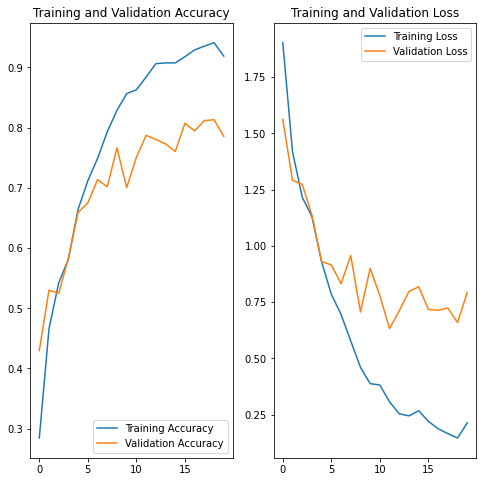

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Overfitting is handled upto some extent. Overall model got 78.54% validation accuracy.